In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
#import seaborn as sns; sns.set()
style.use('fivethirtyeight')
#formatting $$
import matplotlib.ticker as mtick
%matplotlib inline

#utility functions
from cleanup_utilities import misc


In [4]:
!ls -lash ./data/*.csv

3890712 -rw-r--r--  1 ptreszczotko  staff   1.9G Sep 14 09:00 ./data/fpdsAllCSV.csv
  89952 -rw-r--r--  1 ptreszczotko  staff    44M Sep 13 11:09 ./data/fpdsAllCSV100k.csv


# Read in 2016 federal spending data

In [18]:
#Bring in fpds 2016 data 
#this didnt work on a laptop with 16GBs of RAM
df = pd.read_csv('./data/fpdsAllCSV.csv',low_memory=True, dtype={'agencyID': str, 'PIID': str, 'modNumber': str, 'transactionNumber': int, 'obligatedAmount': float, 'baseAndExercisedOptionsValue': float, 'baseAndAllOptionsValue': float , 'DUNSNumber': str, 'principalNAICSCode': str})

df.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning:

Columns (4,13,15,19,40,44,45) have mixed types. Specify dtype option on import or set low_memory=False.



(4616664, 55)

In [19]:
#how many columns were shifted during the import process?
badRows = df[df['status'] != 'F'] # should I drop them?
badRows.head(1)

,agencyID,PIID,modNumber,transactionNumber,IDVAgencyID,IDVPIID,IDVModificationNumber,signedDate,effectiveDate,currentCompletionDate,...,placeOfPerformanceCongressionalDistrict,extentCompeted,solicitationProcedures,typeOfSetAside,evaluatedPreference,numberOfOffersReceived,fedBizOpps,createdBy,lastModifiedBy,status
887489,3600,VA25515F0044,P00003,0,3600,V797P4237B,0,2015-10-09,2015-10-01,2016-09-30,...,A,NaN,NONE,NONE,NaN,0,N,2015-10-09 15:32:07,2017-03-01 10:25:40,NaN


# A bit of EDA first...

### Look at agencies that spend the most

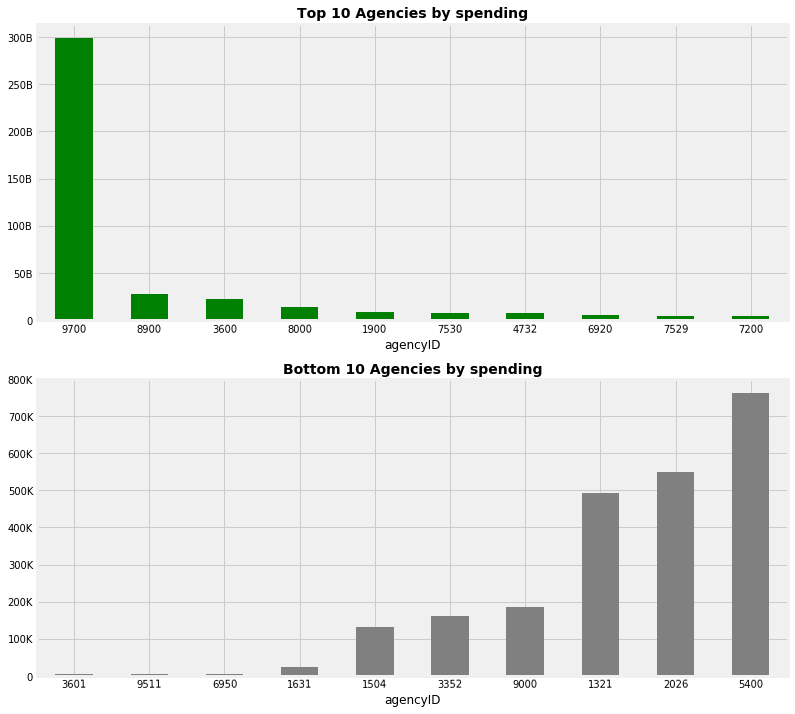

In [20]:
top_n = 10
mostSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=False)[:top_n]
leastSpent = df.groupby('agencyID')['obligatedAmount'].sum().sort_values(ascending=True)

#spending grater than 0
leastSpent = leastSpent[leastSpent > 0][:top_n]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

mostSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='green', ax=ax1, rot=1)

ax1.set_title('Top ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 

leastSpent.plot(kind='bar', x=mostSpent.index,y=mostSpent,
        align='center', width=.5, edgecolor='none', 
        color='gray', ax=ax2, rot=1)

ax2.set_title('Bottom ' + str(top_n) + ' Agencies by spending',fontsize=14, fontweight='bold')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: misc.millify(x))) 


### Convert AgencyIDs to their corresponding names

In [21]:
# Get another data set that maps agencyIds to their names
## Need to import FIPS-95

#import agecncyIds from FIPS 95-2
agencyNames = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='agencyID')
departmentName = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR9NFxZhw7nn8RkJ7Y6UIjSbTObYlcNgwtlA9_dnaSFb2wmbEijgyEVCleQl6rwxxq61UhzgLm2Azmq/pub?output=csv', index_col='departmentID')

#find agencies that are not in the lookup table and add them manually
missingAgencyIDs = df[~df['agencyID'].isin(agencyNames.index)]['agencyID'].unique()

#proceed when all agencies are filled in
missingAgencyIDs

array([], dtype=object)

In [22]:
# add agency names to mostSpent data frame
mostSpentWithNames = pd.merge(agencyNames,pd.DataFrame(mostSpent), left_index = True, right_index = True)

In [23]:
import pandas as pd
import plotly as plotly
#this is a free tier... let others use my api key :)
plotly.tools.set_credentials_file(username='ptreszczotko', api_key='Q5qCy6iLHSjNZznTDEXS');

graphData = pd.DataFrame(columns=['numberOfContracts'])
graphData['numberOfContracts'] = df[df['countryCode'] == 'USA']['state'].value_counts()
graphData['obligatedAmountPerState'] = df.groupby(df[df['countryCode'] == 'USA']['state'])['obligatedAmount'].sum()
graphData['text'] = graphData.index +'\'s total obligated amount: '+ graphData['obligatedAmountPerState'].apply(lambda x: misc.millify(x)).astype(str)

data = [ dict(
        type='choropleth',
        # Colorblind-friendly colors
        autocolorscale = True,
        locations = graphData.index,
        z = graphData['numberOfContracts'],
        locationmode = 'USA-states',
        text = graphData['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of contracts")
        ) ]

layout = dict(
        title = 'Number of contracts awarded in FY2016 per state.',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'))
    
fig = dict( data=data, layout=layout );
plotly.plotly.iplot( fig, filename='d3-cloropleth-map' )

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~ptreszczotko/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


![fy2016](./images/newplot.png "# Contracts per state.")


In [24]:
#try clustering by $ figures
#are there any contracts with null or NA contract value?
df[df['obligatedAmount'].isnull()].shape[0]

df[df.columns[20:49]]
#vendorName or vendorLegalOrganizationName, productOrServiceCode, principalNAICSCode



,descriptionOfContractRequirement,productOrServiceCode,contractBundling,principalNAICSCode,useOfEPADesignatedProducts,placeOfManufacture,vendorName,vendorAlternateName,vendorLegalOrganizationName,vendorDoingAsBusinessName,...,congressionalDistrictCode,vendorSiteCode,vendorAlternateSiteCode,DUNSNumber,parentDUNSNumber,placeOfPerformanceZIPCode,placeOfPerformanceCongressionalDistrict,extentCompeted,solicitationProcedures,typeOfSetAside
0,IGF::OT::IGF Catering Service,S203,D,722310,E,C,"I.L. CREATION OF MARYLAND, INC.",ILC,"I.L. CREATION OF MARYLAND, INC.",NaN,...,8.0,040349990,20852,040349990,NaN,205480235,0,A,NP,NONE
1,''IGF::OT::IGF'' LAN WAN Services,D399,D,541519,E,C,WORLD WIDE TECHNOLOGY INCORPORATED,NaN,WORLD WIDE TECHNOLOGY INCORPORATED,NaN,...,1.0,6149483960000PR,630433237,614948396,NaN,205480001,0,A,MAFO,NONE
2,"IGF::OT::IGF:: Records Management Support, Rec...",R605,D,333298,E,C,PAE LABAT-ANDERSON INCORPORATED,NaN,NaN,NaN,...,11.0,NaN,NaN,038997573,NaN,205480235,0,A,MAFO,NONE
3,IGF::OT::IGF METRO - SmartBenefits,V123,D,485111,E,C,WASHINGTON METROPOLITAN AREA TRANSIT AUTHORITY,WMATA,WASHINGTON METROPOLITAN AREA TRANSIT AUTHORITY,NaN,...,0.0,048855423,200012610,048855423,NaN,205480001,0,C,SSS,NONE
4,IGF::OT::IGF Catering Services,S203,D,722310,E,C,"I.L. CREATION OF MARYLAND, INC.",ILC,"I.L. CREATION OF MARYLAND, INC.",NaN,...,8.0,040349990,20852,040349990,NaN,205480235,0,A,NP,NONE
5,IGF::OT::IGF Catering Service,S203,D,722310,E,C,"I.L. CREATION OF MARYLAND, INC.",ILC,"I.L. CREATION OF MARYLAND, INC.",NaN,...,8.0,040349990,20852,040349990,NaN,205480235,0,A,NP,NONE
6,GAO Building Gas Services,S111,D,221210,E,C,WASHINGTON GAS LIGHT COMPANY,NaN,NaN,NaN,...,NaN,006920607,200802133,006920607,NaN,205480001,0,B,SSS,NONE
7,IGF::OT::IGF New Task Order to provide caterin...,S203,D,722310,E,C,"I.L. CREATION OF MARYLAND, INC.",ILC,"I.L. CREATION OF MARYLAND, INC.",NaN,...,8.0,040349990,20852,040349990,NaN,205480235,0,A,NP,NONE
8,IGF::OT::IGF Westlaw Subscription,R605,D,519190,E,C,WEST PUBLISHING CORPORATION,THOMSON/WEST,WEST PUBLISHING CORPORATION,THOMSON/WEST,...,2.0,148508286,551231340,148508286,NaN,205480001,0,A,NP,NONE
9,IGF::OT::IGF RECORDING AND TRANSCRIBING SERVICES,R603,D,561320,E,C,NEAL R GROSS&CO INC,NaN,NaN,NaN,...,0.0,001627124,200053701,001627124,NaN,205480001,0,D,MAFO,SBA


In [26]:
df['productOrServiceCode'].value_counts()

6515    558333
6505    398193
9130    263966
6640    212519
5340    207373
8940    132008
8910    100465
5680     84866
8915     81251
R499     57480
6135     39536
5330     38568
R425     38279
2540     35666
7030     34206
6530     33958
4730     33778
1560     32266
2610     30996
2310     30295
5310     27526
9140     25185
D399     24868
5305     22825
D304     22487
7110     22177
4820     22151
5935     22137
R408     21793
4330     20925
         ...  
W055         1
K088         1
AT44         1
1361         1
M1MD         1
AS26         1
AA15         1
AN85         1
AT84         1
AV56         1
M162         1
C1MA         1
C115         1
E1KA         1
AG46         1
AL11         1
AH42         1
X1MD         1
6507         1
H288         1
Y173         1
Z2MH         1
E161         1
AT45         1
X161         1
AT16         1
Y1MC         1
AE16         1
Z153         1
W047         1
Name: productOrServiceCode, dtype: int64